# Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

# Setup

In [ ]:
r = 0.03
sig = 0.2
T = 30/365

K=100
M = 100
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
S0 = 100
np.random.seed(20220604)
S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

# Stock price generation

In [ ]:
for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

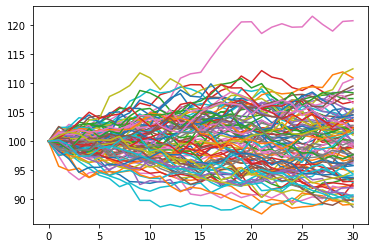

In [ ]:
for i in range(M):
    plt.plot(S[i,:])

plt.show()

In [ ]:
S_max= []
S_min= []
St= []

for i in range(M):
  S_max.append(np.max(S[i,:]))
  S_min.append(np.min(S[i,:]))
  St.append(S[i,N])

# Monte-Carlo

In [ ]:
Lookback_floating_call=[]
Lookback_floating_put=[]
Lookback_fixed_call=[]
Lookback_fixed_put=[]

K=100

In [ ]:
for i in range(M):
    Lookback_floating_call.append(np.maximum(St[i] - S_min[i], 0) * np.exp(-r*T))
    Lookback_floating_put.append(np.maximum(S_max[i] - St[i], 0) * np.exp(-r*T))
    Lookback_fixed_call.append(np.maximum(S_max[i] - K, 0) * np.exp(-r*T))
    Lookback_fixed_put.append(np.maximum(K - S_min[i], 0) * np.exp(-r*T))

In [ ]:
np.mean(Lookback_floating_call)

3.6271719683472328

In [ ]:
np.mean(Lookback_floating_call)

3.6271719683472328

In [ ]:
np.mean(Lookback_floating_put)

4.711929377102244

In [ ]:
np.mean(Lookback_fixed_call)

4.241770056896573

In [ ]:
np.mean(Lookback_fixed_put)

4.097331288552904

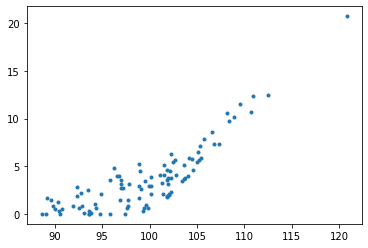

In [ ]:
plt.plot(S[:,-1], Lookback_floating_call, marker=".", linestyle='none')
plt.show()

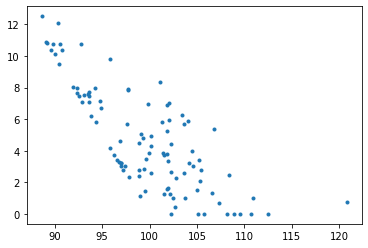

In [ ]:
plt.plot(S[:,-1], Lookback_floating_put, marker=".", linestyle='none')
plt.show()

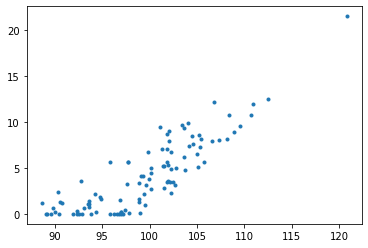

In [ ]:
plt.plot(S[:,-1], Lookback_fixed_call, marker=".", linestyle='none')
plt.show()

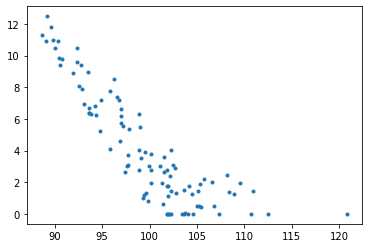

In [ ]:
plt.plot(S[:,-1], Lookback_fixed_put, marker=".", linestyle='none')
plt.show()

# Black-Scholes


In [ ]:
def bscall(S, T, r, sig):
  m=S
  d1 = (np.log(S/m)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/m)+(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  d3 = (np.log(S/m)-(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  C= S*norm.cdf(d1)-m*np.exp(-r*T)*norm.cdf(d2)-((S*(sig**2))/(2*r))*(norm.cdf(-d1)-np.exp(-r*T)*((m/S)**(2*r/sig**2))* norm.cdf(-d3))
  return C

def bsput(S, T, r, sig):
  m=S
  d1 = (np.log(S/m)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/m)+(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  d3 = (np.log(S/m)-(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  C= -S*norm.cdf(-d1)+m*np.exp(-r*T)*norm.cdf(-d2)+(S*(sig**2)/(2*r))*(norm.cdf(d1)-np.exp(-r*T)*((m/S)**(2*r/(sig**2)))*norm.cdf(d3))
  return C


In [ ]:
print(np.mean(S_max))

104.25224212139963


In [ ]:
bscall(S0,T,r,sig)

4.6123721547597745

In [ ]:
bsput(S0,T,r,sig)

4.530281623034849

In [ ]:
def bscall(S, T, r, sig):
  m=S
  d1 = (np.log(S/m)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/m)+(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  d3 = (np.log(S/m)-(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
    
  C= S*norm.cdf(d1)-m*np.exp(-r*T)*norm.cdf(d2)-(S*(sig**2))/(2*r)*(norm.cdf(-d1)-np.exp(-r*T)*(m/S)^(2*r/sig**2)* norm.cdf(-d3))
  return C


  def bsput(S, T, r, sig):
    m=S
  d1 = (np.log(S/m)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
  d2 = (np.log(S/m)+(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
  d3 = (np.log(S/m)-(r- 0.5*sig**2)*T)/(sig*np.sqrt(T))
    
  C= -S*norm.cdf(-d1)-m*np.exp(-r*T)*norm.cdf(-d2)-(S*(sig)**2)/(2*r)*(norm.cdf(d1))-np.exp(-r*T)*(m/S)**(2*r/((sig)**2))* norm.cdf(d3)
  return C

# Delta Hedging

# lookback floating strike call

In [ ]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")  
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")
min = tf.keras.layers.Input(shape=(1,), name='min')

my_input = my_input + [premium] + [hedge_cost] + [price] + [min]

for j in range(N):

    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    
    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price] 

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

get_payoff = tf.keras.layers.Subtract(name='get_payoff')([price, min])
payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x,0), name='payoff')(get_payoff)    
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:

p = np.mean(Lookback_floating_call) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
min = S[:,0]
x = [p]+[c]+[SS]+[min]
y = np.zeros([M,1])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist= model.fit(x,y,batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 34s 217ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/100
25/25 [==============================] - 1s 41ms/step - loss: 3.3317e-04 - val_loss: 0.0013
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 2.4542e-04 - val_loss: 0.0013
Epoch 4/100
25/25 [==============================] - 1s 41ms/step - loss: 1.8358e-04 - val_loss: 0.0013
Epoch 5/100
25/25 [==============================] - 1s 41ms/step - loss: 1.5526e-04 - val_loss: 0.0013
Epoch 6/100
25/25 [==============================] - 1s 40ms/step - loss: 1.5921e-04 - val_loss: 0.0014
Epoch 7/100
25/25 [==============================] - 1s 40ms/step - loss: 1.5302e-04 - val_loss: 0.0014
Epoch 8/100
25/25 [==============================] - 1s 40ms/step - loss: 1.4826e-04 - val_loss: 0.0014
Epoch 9/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6661e-04 - val_loss: 0.0015
Epoch 10/100
25/25 [==============================] - 1s 40ms/step

32/32 [==============================] - 4s 10ms/step


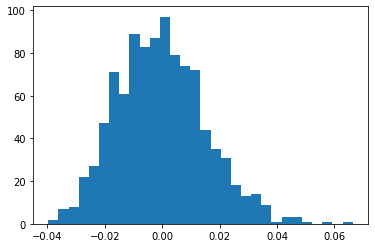

In [ ]:
plt.hist(model.predict(x), bins=30)
plt.show()

32/32 [==============================] - 0s 10ms/step


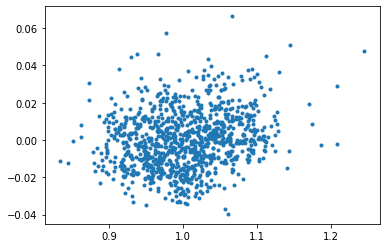

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

# lookback floating strike put

In [ ]:
my_input = []
premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]
price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]
max= tf.keras.layers.Input(shape=(1,), name="maximum")
my_input = my_input + [max]

for j in range(N):

    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    
    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price] 
    
    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price


get_payoff=tf.keras.layers.Subtract(name="get_payoff")([max, price])
payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x, 0), name='payoff')(get_payoff)
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])
model = tf.keras.Model(inputs=my_input, outputs=cum_cost)


In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:

p = np.mean(Lookback_floating_put) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
max = S[:,0]
x = [p]+[c]+[SS]+[max]
y = np.zeros([M,1])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist= model.fit(x,y,batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 35s 200ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/100
25/25 [==============================] - 1s 40ms/step - loss: 3.6922e-04 - val_loss: 0.0013
Epoch 3/100
25/25 [==============================] - 2s 87ms/step - loss: 2.3626e-04 - val_loss: 0.0013
Epoch 4/100
25/25 [==============================] - 2s 98ms/step - loss: 1.9710e-04 - val_loss: 0.0014
Epoch 5/100
25/25 [==============================] - 2s 99ms/step - loss: 1.6997e-04 - val_loss: 0.0015
Epoch 6/100
25/25 [==============================] - 2s 70ms/step - loss: 1.3988e-04 - val_loss: 0.0016
Epoch 7/100
25/25 [==============================] - 1s 42ms/step - loss: 1.9109e-04 - val_loss: 0.0015
Epoch 8/100
25/25 [==============================] - 1s 42ms/step - loss: 1.5683e-04 - val_loss: 0.0016
Epoch 9/100
25/25 [==============================] - 1s 42ms/step - loss: 1.4857e-04 - val_loss: 0.0013
Epoch 10/100
25/25 [==============================] - 1s 42ms/step

32/32 [==============================] - 4s 11ms/step


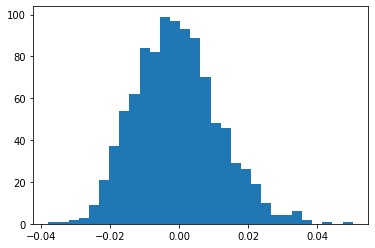

In [ ]:
plt.hist(model.predict(x), bins=30)
plt.show()

32/32 [==============================] - 0s 11ms/step


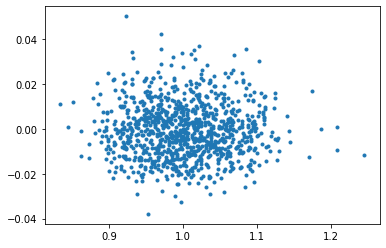

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

# lookback fixed strike call

In [ ]:
my_input = []
premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]
price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]
max= tf.keras.layers.Input(shape=(1,), name="maximum")
my_input = my_input + [max]

for j in range(N):

    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    
    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price] 
    
    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x-K, 0), name='payoff')(max)
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])
model = tf.keras.Model(inputs=my_input, outputs=cum_cost)



In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:

p = np.mean(Lookback_fixed_call) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
max = S[:,0]
x = [p]+[c]+[SS]+[max]
y = np.zeros([M,1])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist= model.fit(x,y,batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 36s 279ms/step - loss: 0.0013 - val_loss: 5.3257e-05
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 5.2352e-04 - val_loss: 1.1052e-04
Epoch 3/100
25/25 [==============================] - 1s 49ms/step - loss: 3.0726e-04 - val_loss: 1.9610e-04
Epoch 4/100
25/25 [==============================] - 1s 49ms/step - loss: 2.0189e-04 - val_loss: 2.8847e-04
Epoch 5/100
25/25 [==============================] - 1s 41ms/step - loss: 1.5129e-04 - val_loss: 2.9083e-04
Epoch 6/100
25/25 [==============================] - 1s 41ms/step - loss: 1.2571e-04 - val_loss: 3.6057e-04
Epoch 7/100
25/25 [==============================] - 1s 40ms/step - loss: 1.1538e-04 - val_loss: 3.6319e-04
Epoch 8/100
25/25 [==============================] - 1s 41ms/step - loss: 1.4014e-04 - val_loss: 3.9318e-04
Epoch 9/100
25/25 [==============================] - 1s 40ms/step - loss: 1.6236e-04 - val_loss: 4.9751e-04
Epoch 10/100
25/25 [==========

32/32 [==============================] - 4s 11ms/step


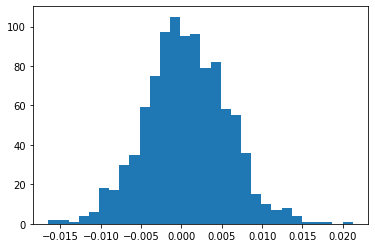

In [ ]:
plt.hist(model.predict(x), bins=30)
plt.show()

32/32 [==============================] - 0s 11ms/step


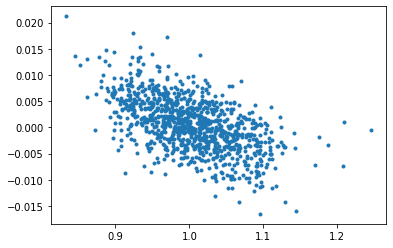

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()

# lookback fixed strike put

In [ ]:
my_input = []
premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]
price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]
min= tf.keras.layers.Input(shape=(1,), name="minimum")
my_input = my_input + [min]

for j in range(N):

    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu')(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    
    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price] 

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    price = new_price

payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(K-x,0), name='payoff')(min)
cum_cost = tf.keras.layers.Add(name="final")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="final_")([cum_cost, premium])
model = tf.keras.Model(inputs=my_input, outputs=cum_cost)


In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:

p = np.mean(Lookback_fixed_put) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
min = S[:,0]
x = [p]+[c]+[SS]+[min]
y = np.zeros([M,1])

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist= model.fit(x,y,batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 35s 197ms/step - loss: 0.0338 - val_loss: 0.0418
Epoch 2/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0261 - val_loss: 0.0421
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0255 - val_loss: 0.0424
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0248 - val_loss: 0.0427
Epoch 5/100
25/25 [==============================] - 1s 39ms/step - loss: 0.0248 - val_loss: 0.0430
Epoch 6/100
25/25 [==============================] - 1s 39ms/step - loss: 0.0241 - val_loss: 0.0432
Epoch 7/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0243 - val_loss: 0.0432
Epoch 8/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0241 - val_loss: 0.0435
Epoch 9/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0245 - val_loss: 0.0436
Epoch 10/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0245 - val_loss: 0.04

32/32 [==============================] - 4s 10ms/step


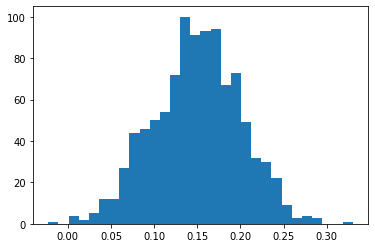

In [ ]:
plt.hist(model.predict(x), bins=30)
plt.show()

32/32 [==============================] - 0s 11ms/step


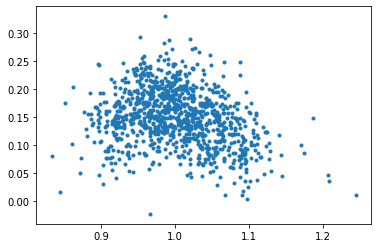

In [ ]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()